In [11]:
import os
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from Models_Pascal.utils import get_train_test_new, get_columns, get_train_test

## Dataset importation

In [2]:
window_length = 96
horizon = 4
total_size = int(24 * 4 * 365 * 2.5)
excluded_columns = [
    "Datetime",
    "Resolution code",
    "Total Load",
    "Most recent forecast",
    "Most recent P10",
    "Most recent P90",
    "Day-ahead 6PM forecast",
    "Day-ahead 6PM P10",
    "Day-ahead 6PM P90",
    "Week-ahead forecast",
    #'Total Load Interpolated',
    "Year",
    # "Month",
    # "Day",
    # "Hour",
    "Minute",
    "Season",
    "Lockdown",
    "Difference with previous load",
    "Difference with previous load interpolated",
    "Total Load Interpolated Persistence",
    "Total Load Persistence",
]
n_feature = 22 - len(excluded_columns)

In [3]:
shift = 4
X_train, Y_train, X_test, Y_test = get_train_test_new(window_length, horizon, total_size, shift, excluded_columns)
# X_train, Y_train, X_test, Y_test = get_train_test(window_length, horizon, total_size, excluded_columns)

100%|██████████| 743/743 [00:00<00:00, 5088.83it/s]


In [4]:
print("Training Input shape:", X_train.shape)
print("Testing Input shape:", X_test.shape)
print("Training Output shape:", Y_train.shape)
print("Testing Output shape:", Y_test.shape)

Training Input shape: (21133, 384)
Testing Input shape: (744, 384)
Training Output shape: (21133, 4)
Testing Output shape: (744, 4)


## Trainning

In [5]:
from sklearn.linear_model import BayesianRidge

BR = BayesianRidge().fit(X_train, Y_train[:, 0])

In [6]:
def reshape_to_feature_window(matrix):
    feautur_list = []
    for i in range(n_feature):
        feautur_list.append([matrix[:, i * window_length : (i + 1) * window_length]])
    test = np.stack(feautur_list).squeeze()

    return test

## Prediction

In [7]:
n_forecasts = horizon  # Number of future steps to forecast
y_hat_BR = []
y_hat_std = []

len_ = X_test.shape[1]

for i in range(X_test.shape[0] - 1):
    current_X = np.expand_dims(X_test[i, :], 0)
    future_x = np.expand_dims(X_test[i + 1, :], 0)
    current_std = 0  # Initial uncertainty is zero
    next_input = current_X
    for step in range(n_forecasts):
        mean_pred, std_pred = BR.predict(next_input, return_std=True)
        # Update total uncertainty: square root of the sum of variances
        total_std = np.sqrt(current_std**2 + std_pred**2)

        y_hat_BR.append(mean_pred.item())
        y_hat_std.append(total_std.item())

        test = reshape_to_feature_window(next_input)
        future_mat = reshape_to_feature_window(future_x)

        test = np.roll(test, -1, axis=1)

        next_input = test
        next_input[0, -1] = mean_pred

        next_input = next_input.reshape(1, -1)
        # Update current uncertainty
        current_std = total_std

df = pd.DataFrame({"Prediction": y_hat_BR, "Std": y_hat_std})
df.to_csv("BaesianBridgeCovariates.csv")

/tmp/ipykernel_464126/2583363127.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_input[0, -1] = mean_pred
/tmp/ipykernel_464126/2583363127.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_input[0, -1] = mean_pred
/tmp/ipykernel_464126/2583363127.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_input[0, -1] = mean_pred
/tmp/ipykernel_464126/2583363127.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecate

## Evaluation

In [8]:
truth_path="/home/schmitt/Documents/Trail/truth_minus_4.csv" # truth csv file with 4 last row deleted (they cannot be predict with a recurseive model)
%run evaluate.py BaesianBridgeCovariates.csv /home/schmitt/Documents/Trail/truth_minus_4.csv

|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|
| |85.8560|128.003|151.364|175.784|0.00806|0.01191|0.01407|0.01647|


## Visulatization 

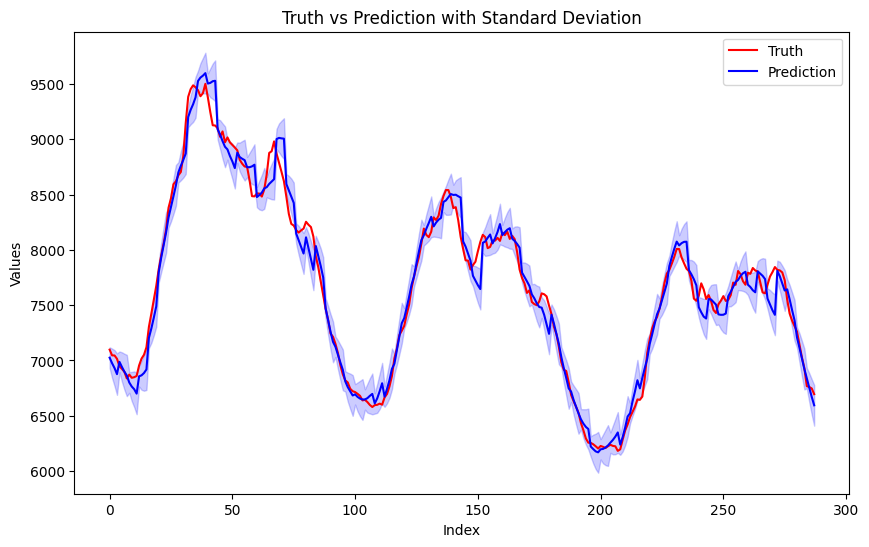

In [9]:
df_truth = pd.read_csv(truth_path)
start = 0
stop = 4 * 24 * 3
# Plotting
plt.figure(figsize=(10, 6))

# Plot the truth line
plt.plot(df[start:stop].index, df_truth["Total Load Interpolated"][start:stop], color="red", label="Truth")

# Plot the prediction line
plt.plot(df[start:stop].index, df["Prediction"][start:stop], color="blue", label="Prediction")

# Add the transparent area (std)
plt.fill_between(df[start:stop].index, df["Prediction"][start:stop] - df["Std"][start:stop], df["Prediction"][start:stop] + df["Std"][start:stop], color="blue", alpha=0.2)

# Adding labels and title
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Truth vs Prediction with Standard Deviation")
plt.legend()

# Show the plot
plt.show()

In [10]:
# Calculate the 95% confidence interval
df["ci_lower"] = df["Prediction"] - 1.96 * df["Std"]
df["ci_upper"] = df["Prediction"] + 1.96 * df["Std"]

# Check if truth is outside the confidence interval
df["outside_ci"] = (df_truth["Total Load Interpolated"] < df["ci_lower"]) | (df_truth["Total Load Interpolated"] > df["ci_upper"])

# Calculate the percentage of times truth is outside the 95% CI
percentage_outside_ci = df["outside_ci"].mean() * 100

print(f"Percentage of time truth is outside the 95% CI: {percentage_outside_ci:.2f}%")

Percentage of time truth is outside the 95% CI: 4.10%
